In [12]:
import sys; sys.path.append('../')
from pathlib import Path
from src.models.torch.embedded_regression import EmbeddedRegression
from src.models.torch.trainer import Trainer
from src.util.data import get_interactions, get_sparsity_factor, get_train_test_ratings
from src.util.metrics import get_jaccard_ranking, get_classification_ranking_metrics, get_r2_score
from src.util.plot import Plot
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')
plot = Plot()

RATINGS_SMALL = Path('../data/ratings_small.csv')
MOVIES = Path("../data/movies_metadata.csv")
OUTPUT_PATH = Path('../models/content-based.pt')
EMB = "../data/emb.p"
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import torch
import torchvision
from abc import ABC
import pickle
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from typing import List
from sklearn import preprocessing
from tqdm import tqdm

tqdm.pandas()
#EMB = r"C:\Users\Wilk\PiSR1\data\emb.p"
#RATINGS_SMALL = r"C:\Users\Wilk\PiSR1\data\ratings_small.csv"

to_drop = ["1997-08-20","2012-09-29","2014-01-01"]
SEED = 42
DEVICE = torch.device("cpu")
if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
DEVICE

device(type='cuda')

In [13]:
from typing import Tuple

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tqdm.auto import tqdm
from sklearn.utils import shuffle
def get_train_test_ratings(
    ratings: pd.DataFrame
) -> Tuple[pd.DataFrame, pd.DataFrame]:

    movies, counts = np.unique(ratings['movieId'].values, return_counts=True)
    single_movies = set(movies[counts == 1])
    single_ratings = ratings.loc[ratings['movieId'].isin(single_movies)]

    ratings = ratings.loc[~ratings['movieId'].isin(single_movies)]

    train_ratings, test_ratings = train_test_split(
        ratings,
        test_size=0.1,
        stratify=ratings['movieId'].values,
        random_state=42
    )

    train_ratings = pd.concat([train_ratings, single_ratings])
    train_ratings = shuffle(train_ratings, random_state=42)

    return train_ratings, test_ratings

In [14]:
column_list = ["id","adult","budget","popularity","runtime","vote_average","vote_count","original_language","belongs_to_collection","spoken_languages","genres"]
def getMoviesContentDataset(Embeddings=False):
    movies = pd.read_csv(MOVIES)
    ratings = pd.read_csv(RATINGS_SMALL)
    
    for drop_error in to_drop:
        movies = movies[movies.id != drop_error]
    movies.id = movies.id.astype('int64')
    dataset = ratings.merge(movies[column_list], left_on='movieId', right_on='id')
    
    dataset = dataset.dropna()    
    
    budget_Scaler = preprocessing.StandardScaler().fit(dataset.budget.to_numpy().reshape(-1, 1))
    
    lang_encoder = preprocessing.LabelEncoder().fit(dataset.original_language)
    
    genres_encoder = preprocessing.LabelEncoder().fit(dataset.genres)
    
    spoken_languages_encoder = preprocessing.LabelEncoder().fit(dataset.spoken_languages)
    
    adult_encoder = preprocessing.LabelEncoder().fit(dataset.adult)
    
    belongs_to_collection_encoder = preprocessing.LabelEncoder().fit(dataset.belongs_to_collection)
    
    dataset.belongs_to_collection = belongs_to_collection_encoder.transform(dataset.belongs_to_collection)
    dataset.original_language = lang_encoder.transform(dataset.original_language)
    dataset.adult = adult_encoder.transform(dataset.adult)
    dataset.spoken_languages = spoken_languages_encoder.transform(dataset.spoken_languages)
    dataset.genres = genres_encoder.transform(dataset.genres)
    dataset.budget = budget_Scaler.transform(dataset.budget.to_numpy().reshape(-1, 1))
    dataset.movieId = dataset.movieId.astype(int)
    dataset.popularity = dataset.popularity.astype("float64")
    dataset.original_language = dataset.popularity.astype("int32")
    dataset.belongs_to_collection = dataset.popularity.astype("int32")
    dataset.vote_count = dataset.vote_count.astype("int32")
    dataset.userId = dataset.userId.astype(int)
    dataset.movieId = dataset.movieId.astype(int)
    
    if Embeddings:
        movies_emb = pickle.load( open( EMB, "rb" ) )
        dataset = dataset.merge(movies_emb[['id',"vector"]], left_on='movieId', right_on='id')
        dataset.vector = dataset.vector.to_numpy()
        dataset = dataset.drop(["id_x","id_y"], axis=1)
    else:
        dataset=dataset.drop(["id"], axis=1)
    dataset=dataset.drop(["timestamp"],axis=1)
    return dataset
dataset = getMoviesContentDataset(True)

In [15]:
dataset.dtypes

userId                     int32
movieId                   object
rating                   float64
adult                      int32
budget                   float64
popularity               float64
runtime                  float64
vote_average             float64
vote_count                 int32
original_language          int32
belongs_to_collection      int32
spoken_languages           int32
genres                     int32
vector                    object
dtype: object

In [16]:
train_ratings, test_ratings = get_train_test_ratings(dataset)
target_train = torch.Tensor(train_ratings.rating.values)
target_test  = torch.Tensor(test_ratings.rating.values) 
train_ratings= train_ratings.drop(["movieId","rating"],axis=1)
test_ratings = test_ratings.drop(["movieId","rating"],axis=1)

In [17]:
train_ratings_t = torch.Tensor(train_ratings.drop(["vector"],axis=1).values)
test_ratings_t = torch.Tensor(test_ratings.drop(["vector"],axis=1).values)

In [18]:
vec_train = torch.Tensor(list(train_ratings.vector.values))
vec_test = torch.Tensor(list(test_ratings.vector.values))

In [19]:
train = torch.cat((vec_train,train_ratings_t),dim=1)
test = torch.cat((vec_test,test_ratings_t),dim=1)

In [20]:
train.shape

torch.Size([9718, 779])

In [21]:
dataset_tensor_train = TensorDataset(train, target_train)
dataset_tensor_test = TensorDataset(test, target_test)

In [22]:
BATCH_SIZE = 30

In [23]:
data_loader_train = DataLoader(dataset_tensor_train, batch_size=BATCH_SIZE)
data_loader_test = DataLoader(dataset_tensor_test, batch_size=BATCH_SIZE)

In [24]:
from abc import ABC
from typing import List, Tuple
class ContentBaseRecommenderSystem(nn.Module):

    def __init__(self, input_size, hidden_feature_size):
        super().__init__()
        self.movies = None
        self.ratings = None
        self.fc1 = nn.Linear(input_size, hidden_feature_size) #fully connected 
     
        self.fc2 = nn.Linear(hidden_feature_size, hidden_feature_size)
        self.fc3 = nn.Linear(hidden_feature_size, hidden_feature_size)
        self.out_layer = nn.Linear(hidden_feature_size, 1)
        self.act_fn = F.relu
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.act_fn(x)
        
        x= self.fc2(x)
        x = self.act_fn(x)
             
        x = self.act_fn(self.fc3(x))
        out = F.sigmoid(self.out_layer(x))
        
        return out*5
    
    def predict(self, user_id: int) -> List[int]:
        """
        Predicts ranking of movies to watch for a user.

        Parameters
        ----------
        user_id : int
            User's id from the data set.

        Returns
        -------
        List[int]
            List of movies ids. Best recommendations first.
        """
        movies, rating = self.predict_scores(user_id)
        return list(movies)
        

    def predict_score(self, user_id: int, movie_id: int) -> float:
        """
        Predicts score for a given movie that a user would give.

        Parameters
        ----------
        user_id : int
            User's id from the data set.
        movie_id : int
            Movie's id from the data set.

        Returns
        -------
        float
            Predicted movie's score in range [0, 5].
        """
        df = getMoviesContentDataset(True)
        
        df = df.loc[df['movieId'] == movie_id] 
        df_features = df.drop(["movieId","rating","vector"],axis=1).loc[0]
        df_vector = df.vector.loc[0]
        x_input = torch.Tensor(df_features.values)
        vec_input = torch.Tensor(list(df_vector))

        input = torch.cat((x_input,vec_input),dim=0)
        
        prediction = self.forward(input).item()
        return prediction
        

    def predict_scores(self, user_id: int) -> Tuple[np.ndarray, np.ndarray]:
        """
        Predicts scores for all the movies, that a user would give.

        Parameters
        ----------
        user_id : int
            User's id from the data set.

        Returns
        -------
        Tuple[np.ndarray, np.ndarray]:
            Ranked movies with their scores.
        """
        df = getMoviesContentDataset(True)
        df.userId = user_id
       
        
        df = df.drop_duplicates('movieId')
        movieIds = df.movieId.values
        df_features = df.drop(["movieId","rating","vector"],axis=1)
        df_vector = df.vector.values
        x_input = torch.Tensor(df_features.values)
        vec_input = torch.Tensor(list(df_vector))
        input = torch.cat((x_input,vec_input),dim=1)
   
        prediction = self.forward(input).detach().numpy()
    
        ranking = pd.DataFrame(
            zip(movieIds, prediction),
            columns=['movie', 'rating']
        )

        ranking = ranking.sort_values(
            by='rating',
            ascending=False
        )
        return ranking.movie.values, np.concatenate( ranking.rating.values, axis=0 )
        
        
    def get_user_data(self, user_id: int, exlude=False) -> pd.DataFrame:
        df = self.getMoviesContentDataset(True)
        if exlude:
            df = df.loc[df['userId'] != user_id]
        else:
            df = df.loc[df['userId'] == user_id]
        return df
    
    def setup(self):
        self.movies = pd.read_csv(MOVIES)
        self.ratings = pd.read_csv(RATINGS_SMALL)
    def getMoviesContentDataset(self, Embeddings=False) -> pd.DataFrame:
        movies = self.movies
        ratings = self.ratings
        to_drop = ["1997-08-20","2012-09-29","2014-01-01"]
        for drop_error in to_drop:
            movies = movies[movies.id != drop_error]
        movies.id = movies.id.astype('int64')
        dataset = ratings.merge(movies[column_list], left_on='movieId', right_on='id')

        dataset = dataset.dropna()    

        budget_Scaler = preprocessing.StandardScaler().fit(dataset.budget.to_numpy().reshape(-1, 1))

        lang_encoder = preprocessing.LabelEncoder().fit(dataset.original_language)

        genres_encoder = preprocessing.LabelEncoder().fit(dataset.genres)

        spoken_languages_encoder = preprocessing.LabelEncoder().fit(dataset.spoken_languages)

        adult_encoder = preprocessing.LabelEncoder().fit(dataset.adult)

        belongs_to_collection_encoder = preprocessing.LabelEncoder().fit(dataset.belongs_to_collection)

        dataset.belongs_to_collection = belongs_to_collection_encoder.transform(dataset.belongs_to_collection)
        dataset.original_language = lang_encoder.transform(dataset.original_language)
        dataset.adult = adult_encoder.transform(dataset.adult)
        dataset.spoken_languages = spoken_languages_encoder.transform(dataset.spoken_languages)
        dataset.genres = genres_encoder.transform(dataset.genres)
        dataset.budget = budget_Scaler.transform(dataset.budget.to_numpy().reshape(-1, 1))
        dataset.popularity = dataset.popularity.astype("float64")

        dataset.userId = dataset.userId.astype(int)
        dataset.movieId = dataset.movieId.astype(int)

        if Embeddings:
            movies_emb = pickle.load( open( EMB, "rb" ) )
            dataset = dataset.merge(movies_emb[['id',"vector"]], left_on='movieId', right_on='id')
            dataset = dataset.drop(["id_x","id_y"], axis=1)
        else:
            dataset=dataset.drop(["id"], axis=1)
        dataset=dataset.drop(["timestamp"],axis=1)
        return dataset


In [25]:
LR = 0.001
EPOCHS = 20
HIDDEN_SIZE = 254
FLAT_SIZE = 779
OUTPUT = 1

loss_func = torch.nn.MSELoss()

In [26]:
import torch.optim as optim
from sklearn.metrics import r2_score

In [27]:
history = {
    'loss':[],
    'loss_test':[],
    'r2_score_train':[],
    'r2_score_test':[],
}
net = ContentBaseRecommenderSystem(FLAT_SIZE,HIDDEN_SIZE)

optimizer = optim.Adam(net.parameters(),lr=LR)
for epoch in tqdm(range(EPOCHS)):
    loss_sum = []
    train_pred = []
    train_pred_t = []
    for train, target in data_loader_train:
        prediction = net(train)
        loss = loss_func(torch.squeeze(prediction), target)
        loss_sum.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_pred.append(prediction.detach().numpy())
        train_pred_t.append(target.detach().numpy())
    loss_test = []
    with torch.no_grad():
        test_pred = []
        test_pred_t = []
        
        for test, target in data_loader_test:
            prediction = net(test) 
            loss = loss_func(torch.squeeze(prediction), target)
            loss_test.append(loss)
            test_pred.append(prediction.numpy())
            test_pred_t.append(target.numpy())
        test_pred = np.concatenate(np.squeeze(test_pred))
        test_pred_t = np.concatenate(np.squeeze(test_pred_t))
    history['loss'].append(sum(loss_sum)/len(loss_sum))
    history['loss_test'].append(sum(loss_test)/len(loss_test))
    history['r2_score_test'].append(r2_score(test_pred_t,test_pred))
    history['r2_score_train'].append(r2_score(test_pred_t,test_pred))
        
        

  0%|          | 0/20 [00:00<?, ?it/s]

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

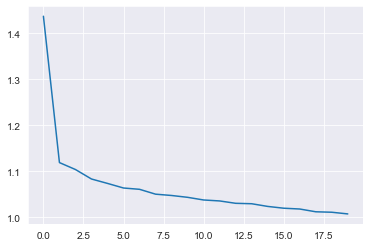

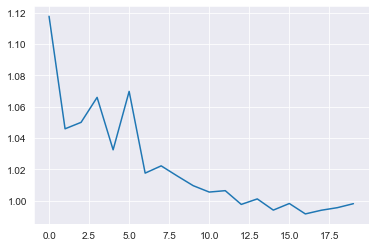

In [29]:
sns.set_style("darkgrid")
plt.plot(history['loss'])
plt.show()
plt.plot(history['loss_test'])
plt.show()

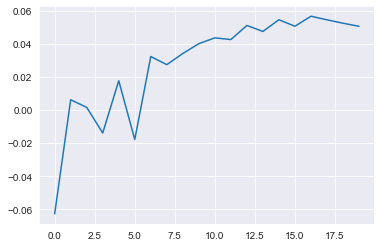

In [30]:
sns.set_style("darkgrid")
plt.plot(history['r2_score_test'])
plt.show()

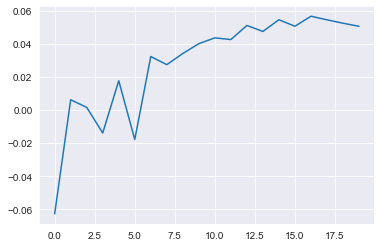

In [31]:
sns.set_style("darkgrid")
plt.plot(history['r2_score_train'])
plt.show()

In [35]:

net.setup()
train_ratings, test_ratings = get_train_test_ratings(dataset)

# Tests


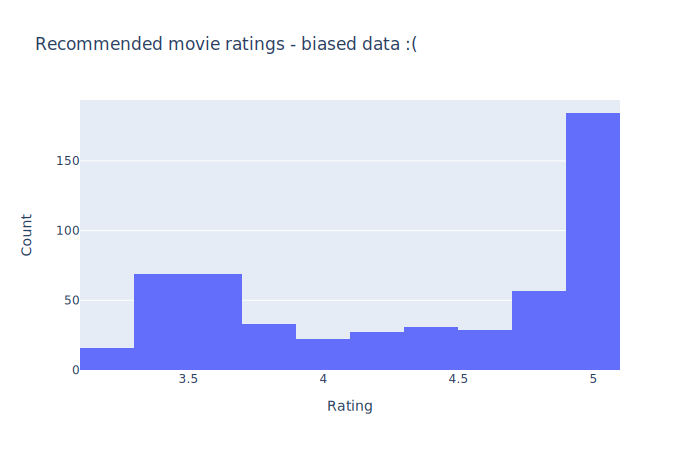

In [36]:
with torch.no_grad():
    _, scores = net.predict_scores(7)
    plot.histogram(
        x=scores,
        title='Recommended movie ratings - biased data :(',
        xaxis_title='Rating',
        yaxis_title='Count'
    )

Testing predictions:   0%|          | 0/421 [00:00<?, ?it/s]

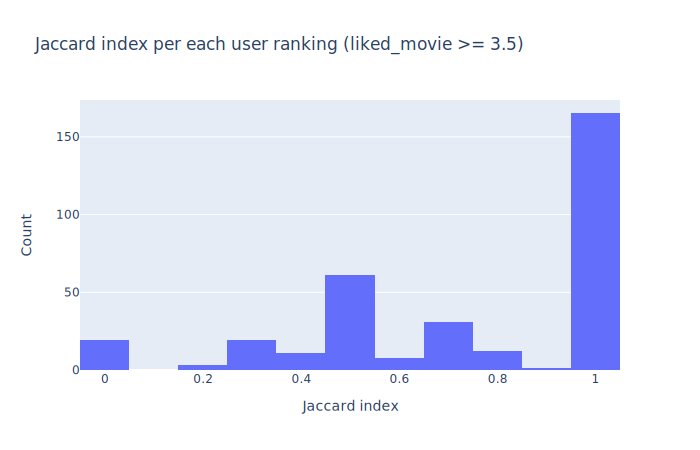

In [37]:
with torch.no_grad():
    jaccard_ranking = get_jaccard_ranking(net, test_ratings)
    plot.histogram(
        x=jaccard_ranking,
        title='Jaccard index per each user ranking (liked_movie >= 3.5)',
        xaxis_title='Jaccard index',
        yaxis_title='Count'
    )

In [38]:
with torch.no_grad():
    r2_score = get_r2_score(net, test_ratings)
    print(f'\n\nr2 score: {r2_score:.3f}')

Testing predictions:   0%|          | 0/421 [00:00<?, ?it/s]



r2 score: -1.025


Testing predictions:   0%|          | 0/421 [00:00<?, ?it/s]

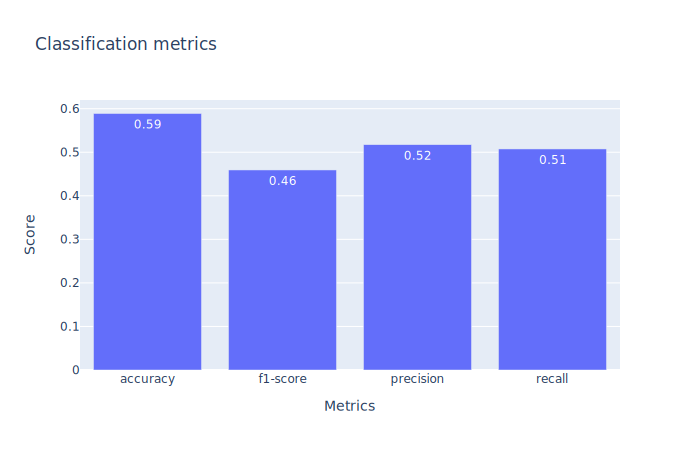

In [40]:
with torch.no_grad():
    classification_metrics = get_classification_ranking_metrics(net, test_ratings)
    plot.bar(
        classification_metrics,
        title='Classification metrics',
        xaxis_title='Metrics',
        yaxis_title='Score'
    )